Comparison of the rules extracted from a tree with parameter maximum depth of 9:
- rule 1 (node 29/29): equal
- rule 2 (node 37/37): equal
- rule 3 (node 31/31): equal
- rule 4 (node 20/20): equal
- rule 5 (node 16/16): equal
- rule 6 (node 11/10): Hours per week $\leq 42.5$ instead of Country $>4.5$
- rule 7 (node 41/41): equal
- rule 8 (node 46/46): equal

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
from comparers import ModelComparer
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import classification_report
from util import RuleClassifier, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate_counterfactual_fidelity, print_complexity, calc_constraint_error
from surrogate_tree import train_surrogate_tree, tree_to_rules, plot_surrogate_tree,\
                 get_feature_importances, plot_feature_importances, plot_tree_leafs_for_class,\
                 tree_to_constraint_matrix, constraint_matrix_to_rules, extract_rules, print_rules,\
                 evaluate

In [3]:
with open('task_with_noise.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Explanations

In [5]:
mclass_diff = comparer.predict_mclass_diff(X)

In [6]:
with open('ground_truth.(False, True).pickle', 'rb') as f:
    ground_truth_instance_indices_01, ground_truth_01 = pickle.load(f)
with open('ground_truth.(True, False).pickle', 'rb') as f:
    ground_truth_instance_indices_10, ground_truth_10 = pickle.load(f)

## Tree with Depth 13

In [7]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=13)

CPU times: user 2.29 ms, sys: 164 µs, total: 2.46 ms
Wall time: 2.48 ms


In [8]:
evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       1.00      1.00      1.00       786
 (False, True)       0.92      1.00      0.96        12
  (True, True)       1.00      0.99      1.00       179

      accuracy                           1.00       977
     macro avg       0.97      1.00      0.99       977
  weighted avg       1.00      1.00      1.00       977



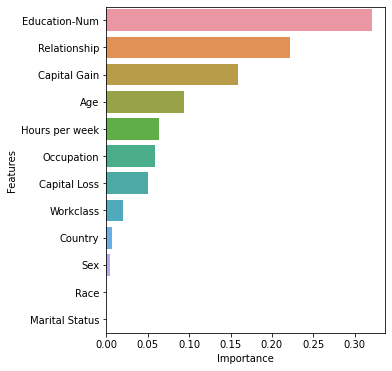

In [9]:
feature_importances, feature_order = get_feature_importances(model)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5,6))

In [10]:
constraints, rules, class_occurences, labels, instance_indices_per_rule =\
    extract_rules(model, feature_names, comparer.difference_classes, X, mclass_diff)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. Age > 59.0 and 9.5 < `Education-Num` <= 12.5 and Occupation <= 13.5 and Relationship > 3.5 and `Capital Gain` <= 5095.5 and 37.5 < `Hours per week` <= 42.5 => (False, True) [0, 3, 0]
2. 42.5 < Age <= 59.0 and Workclass <= 5.5 and 9.5 < `Education-Num` <= 12.5 and 2.0 < Occupation <= 13.5 and Relationship > 3.5 and `Capital Gain` <= 5095.5 and `Capital Loss` <= 0.5 and 37.5 < `Hours per week` <= 41.5 => (False, True) [0, 2, 1]
3. 36.5 < Age <= 37.5 and Workclass > 3.0 and `Education-Num` > 12.5 and Relationship > 3.5 and 31.0 < `Hours per week` <= 50.0 and Country > 14.0 => (False, True) [0, 1, 0]
4. 27.0 < Age <= 31.5 and `Education-Num` > 13.5 and Occupation > 3.5 and Relationship > 3.5 => (False, True) [0, 1, 0]
5. 29.0 < Age <= 31.5 and 12.5 < `Education-Num` <= 13.5 and 3.5 < Occupation <= 9.0 and Relationship > 3.5 and `Hours per week` <= 42.5 => (False, True) [0, 1, 0]
6. 46.5 < Age <= 50.5 and Workclass > 4.5 and `Education-Num` <= 9.5 and Relationship > 3.5 and `Capital Gain

### Evaluation

In [11]:
constraints_01 = [constraint for constraint, label in zip(constraints, labels) if label == comparer.check_class('(False, True)')[0]]

In [12]:
instance_indices_per_rule_01 = [instance_indices for instance_indices, label in zip(instance_indices_per_rule, labels) if label == comparer.check_class('(False, True)')[0]]

#### Global Fidelity

In [13]:
evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       1.00      1.00      1.00       786
 (False, True)       0.92      1.00      0.96        12
  (True, True)       1.00      0.99      1.00       179

      accuracy                           1.00       977
     macro avg       0.97      1.00      0.99       977
  weighted avg       1.00      1.00      1.00       977



#### Counterfactual Fidelity Error

In [14]:
evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices_01, ground_truth_01, instance_indices_per_rule_01, constraints_01)

invalid value encountered in true_divide


(            Age  Workclass  Education-Num  Marital Status  Occupation  \
 701 lower  24.0        NaN            0.5             NaN         NaN   
     upper   NaN        NaN            0.5             NaN        10.5   
 948 lower  16.0        NaN            0.5             NaN         NaN   
     upper   NaN        NaN            0.5             NaN        10.5   
 961 lower  -2.0        NaN            0.5             NaN         NaN   
     upper   NaN        NaN            0.5             NaN         9.5   
 64  lower  -0.5        NaN            0.5             NaN         2.0   
     upper  -2.0        0.5            0.5             NaN        10.5   
 406 lower  -0.5        NaN            0.5             NaN         2.0   
     upper  -2.0        0.5            0.5             NaN        10.5   
 70  lower   3.5        2.0            0.5             NaN         NaN   
     upper  -5.5        NaN            NaN             NaN         NaN   
 883 lower   0.0        NaN           

#### Complexity

In [15]:
print_complexity(constraints_01)

Number of rules: 9
Number of constraints: 67 (7.4 per rule)


#### Stability

In [16]:
with open('explanation-baseline-orig.pickle', 'rb') as f:
    constraints_01_orig, instance_indices_per_rule_01_orig = pickle.load(f)

1:1 mapping is possible.

In [23]:
indices = np.where(comparer.predict_mclass_diff(X) == 1)[0]
mapping_data = pd.DataFrame(columns=indices, index=['original', 'test'], data=[
    RuleClassifier(feature_names, constraint_matrix_to_rules(constraints_01_orig, feature_names)).apply(X[indices]),
    RuleClassifier(feature_names, rules).apply(X[indices])]).T
mask = ~np.any(mapping_data == 0, 1)
mapping_data = mapping_data[mask]
for orig_rule_id in np.unique(mapping_data['original']):
    print(f'rule {int(orig_rule_id)}:')
    print(mapping_data.loc[mapping_data['original'] == orig_rule_id, 'test'].value_counts())

rule 1:
1    3
Name: test, dtype: int64
rule 2:
2    2
Name: test, dtype: int64
rule 3:
3    1
Name: test, dtype: int64
rule 4:
4    1
Name: test, dtype: int64
rule 5:
5    1
Name: test, dtype: int64
rule 6:
6    1
Name: test, dtype: int64
rule 7:
7    1
Name: test, dtype: int64
rule 8:
8    1
Name: test, dtype: int64
rule 9:
9    1
Name: test, dtype: int64


In [18]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    calc_constraint_error(feature_names, constraints_01_orig, constraints_01)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [19]:
rmse

Age               0.554700
Workclass         0.000000
Education-Num     0.000000
Marital Status         NaN
Occupation        3.895969
Relationship      0.000000
Race                   NaN
Sex                    NaN
Capital Gain      0.000000
Capital Loss      0.500000
Hours per week    0.000000
Country           0.000000
dtype: float64

In [20]:
boundary_miss_rate

Age               0.000
Workclass         0.400
Education-Num     0.000
Marital Status    1.000
Occupation        0.125
Relationship      0.000
Race                NaN
Sex                 NaN
Capital Gain      0.000
Capital Loss      0.000
Hours per week    0.000
Country           0.000
dtype: float64

In [21]:
boundary_add_rate

Age               0.071429
Workclass         0.250000
Education-Num     0.000000
Marital Status         NaN
Occupation        0.125000
Relationship      0.000000
Race                   NaN
Sex                    NaN
Capital Gain      0.000000
Capital Loss      0.500000
Hours per week    0.111111
Country           0.000000
dtype: float64

In [22]:
errors

Age  Workclass  Education-Num  Marital Status  Occupation  \
1 lower  0.0        NaN            0.0             NaN         NaN   
  upper  NaN        NaN            0.0             NaN         0.0   
2 lower  0.0        NaN            0.0             NaN         NaN   
  upper  0.0        0.0            0.0             NaN        10.0   
3 lower  0.0        NaN            0.0             NaN         NaN   
  upper  0.0        NaN            NaN             NaN         NaN   
4 lower  0.0        NaN            0.0             NaN         0.0   
  upper  0.0        NaN            NaN             NaN         NaN   
5 lower  2.0        NaN            0.0             NaN        -2.5   
  upper  0.0        NaN            0.0             NaN         0.0   
6 lower  0.0        0.0            NaN             NaN         NaN   
  upper  0.0        NaN            0.0             NaN         NaN   
7 lower  0.0        NaN            NaN             NaN         0.0   
  upper  0.0        0.0            0.0             NaN         0.0   
8 lower  NaN        NaN            NaN             NaN         NaN   
  upper  NaN        NaN            NaN             NaN         NaN   
9 lower  NaN        NaN            0.0             NaN         NaN   
  upper  NaN        NaN            NaN             NaN         NaN   

         Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
1 lower           0.0   NaN  NaN           NaN           NaN             0.0   
  upper           NaN   NaN  NaN           0.0           NaN             0.0   
2 lower           0.0   NaN  NaN           NaN           NaN             0.0   
  upper           NaN   NaN  NaN           0.0           NaN             0.0   
3 lower           0.0   NaN  NaN           NaN           NaN             0.0   
  upper           NaN   NaN  NaN           NaN           NaN             0.0   
4 lower           0.0   NaN  NaN           NaN           NaN             NaN   
  upper           NaN   NaN  NaN           NaN           NaN             NaN   
5 lower           0.0   NaN  NaN           NaN           NaN             NaN   
  upper           NaN   NaN  NaN           NaN           NaN             NaN   
6 lower           0.0   NaN  NaN           NaN           NaN             NaN   
  upper           NaN   NaN  NaN           0.0           0.5             0.0   
7 lower           0.0   NaN  NaN           NaN           NaN             NaN   
  upper           NaN   NaN  NaN           0.0           0.5             0.0   
8 lower           NaN   NaN  NaN           0.0           NaN             NaN   
  upper           0.0   NaN  NaN           0.0           NaN             NaN   
9 lower           NaN   NaN  NaN           NaN           NaN             NaN   
  upper           0.0   NaN  NaN           0.0           NaN             NaN   

         Country  
1 lower      NaN  
  upper      NaN  
2 lower      NaN  
  upper      NaN  
3 lower      0.0  
  upper      NaN  
4 lower      NaN  
  upper      NaN  
5 lower      NaN  
  upper      NaN  
6 lower      NaN  
  upper      NaN  
7 lower      NaN  
  upper      NaN  
8 lower      NaN  
  upper      NaN  
9 lower      NaN  
  upper      NaN